<h1><center>Stock Prices Analysis and Prediction</center></h1>

### Sonal Doomra <br> UMID: 8852 9245 <br> UniqName: dsonal <br> SI 671 - Data Mining Final Project

In this project, I have used Investor's Exchange API to collect historical stock data from S&P 500 companies. This data was used for initial investigation of different factors contributing to the final closing stock price each day. The insights gained from the analysis was then used in creating predictive models for predicting future closing price. 

The file 'all_stocks_5yr.csv' contains all 500 companies' historical stock data which was collected by running the script in 'Collect_Stock_Data.ipynb' and then 'merge.sh' was used to merge all stocks csv file into one file. 

### Import libraries

In [81]:
from datetime import datetime
from concurrent import futures
from pandas import DataFrame
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, Activation

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import seaborn as sns
import time
import dateutil.parser as dp
import math
import os

### Read in the pandas dataframe

In [14]:
df_data = pd.read_csv("all_stocks_5yr.csv")

In [3]:
df_data.head()

,date,open,high,low,close,volume,Name
0,2013-11-11,22.2732,22.4648,22.0911,22.2923,3508100,AAL
1,2013-11-12,22.2827,24.4190,21.5547,22.5318,40091800,AAL
2,2013-11-13,23.2024,23.2790,22.1582,22.3306,20087200,AAL
3,2013-11-14,22.7905,22.8000,22.3977,22.6659,12641900,AAL
4,2013-11-15,22.7330,23.0395,22.3402,22.8863,13660700,AAL


In [13]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621821 entries, 0 to 621820
Data columns (total 7 columns):
date      621821 non-null datetime64[ns]
open      621808 non-null float64
high      621811 non-null float64
low       621811 non-null float64
close     621821 non-null float64
volume    621821 non-null int64
Name      621821 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.2+ MB


In [15]:
df_data.describe()

,open,high,low,close,volume
count,621808.000000,621811.000000,621811.000000,621821.000000,6.218210e+05
mean,86.232575,87.035208,85.402643,86.238464,4.305415e+06
std,106.905869,107.860852,105.871540,106.893309,8.415813e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,39.233200,39.625000,38.845100,39.241400,1.095068e+06
50%,62.741250,63.320000,62.158900,62.759300,2.112079e+06
75%,98.298650,99.176800,97.391450,98.293900,4.337810e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


### Data Preprocessing

In [16]:
# change date to datetime type of variable
df_data['date'] = pd.to_datetime(df_data['date'])

In [17]:
df_data.head()

,date,open,high,low,close,volume,Name
0,2013-11-11,22.2732,22.4648,22.0911,22.2923,3508100,AAL
1,2013-11-12,22.2827,24.4190,21.5547,22.5318,40091800,AAL
2,2013-11-13,23.2024,23.2790,22.1582,22.3306,20087200,AAL
3,2013-11-14,22.7905,22.8000,22.3977,22.6659,12641900,AAL
4,2013-11-15,22.7330,23.0395,22.3402,22.8863,13660700,AAL


In [18]:
df = df_data.dropna() # drop null values from dataframe

In [19]:
df.info() #get info once more--> Now there are 621808 entries remaining

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621808 entries, 0 to 621820
Data columns (total 7 columns):
date      621808 non-null datetime64[ns]
open      621808 non-null float64
high      621808 non-null float64
low       621808 non-null float64
close     621808 non-null float64
volume    621808 non-null int64
Name      621808 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 38.0+ MB


In [20]:
df.describe()

,open,high,low,close,volume
count,621808.000000,621808.000000,621808.000000,621808.000000,6.218080e+05
mean,86.232575,87.035386,85.402816,86.238224,4.305497e+06
std,106.905869,107.861079,105.871763,106.892863,8.415881e+06
min,1.620000,1.690000,1.500000,1.590000,1.010000e+02
25%,39.233200,39.624975,38.844775,39.240300,1.095112e+06
50%,62.741250,63.320000,62.158950,62.759550,2.112152e+06
75%,98.298650,99.176900,97.392025,98.294050,4.337907e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [21]:
# Let's analyze some of the stocks.
amzn = df.loc[df['Name'] == 'AMZN']
amzn.head()


,date,open,high,low,close,volume,Name
46615,2013-11-11,350.59,355.3700,348.060,354.378,2262538,AMZN
46616,2013-11-12,352.99,355.4826,347.282,349.530,2344304,AMZN
46617,2013-11-13,347.40,356.2200,345.680,356.220,2777832,AMZN
46618,2013-11-14,357.39,368.9400,356.430,367.396,4164128,AMZN
46619,2013-11-15,367.63,372.9000,365.550,369.170,4494773,AMZN


In [23]:
# Simple plotting of Company's Stock Price
# First Subplot
def plotting(data, company):
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,14))
    ax1.plot(data["date"], data["close"], color="blue")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Stock Price")
    ax1.set_title(company + " Price History")
    
    
    # Second Subplot
    ax1.plot(data["date"], data["high"], color="green")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Stock Price")
    ax1.set_title(company+"  Price History")

    print("\n\n\n")
    # Third Subplot
    ax1.plot(data["date"], data["low"], color="red")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Stock Price")
    ax1.set_title(company + " Price History")
    ax1.legend(['Close Price','High Price', 'Low Price'], loc='upper left')

    # Fourth Subplot
    ax2.plot(data["date"], data["volume"], color="orange")
    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("Stock Price")
    ax2.set_title(company +" Volume History")
    #plt.set_legend(['Close Price','Actual Price', 'Predicted Price'], loc='upper left')
    plt.show()

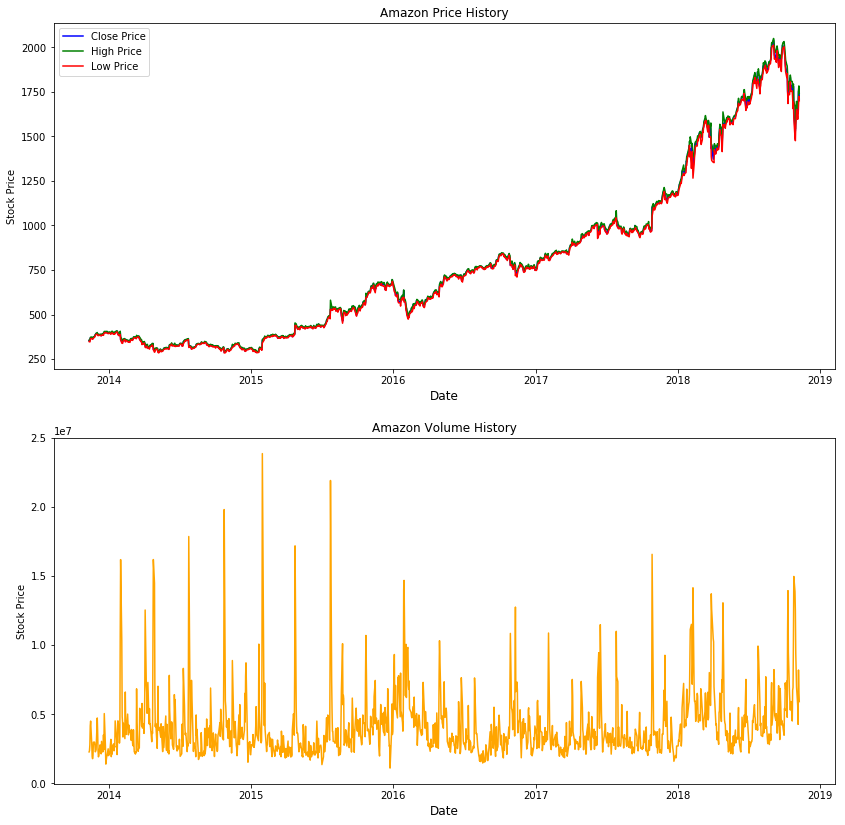

In [24]:
plotting(amzn, "Amazon")

In [16]:
# It might be interesting to see Apples stock prices in 5 years

In [25]:
# Let's analyze some of the stocks.
appl = df.loc[df['Name'] == 'AAPL']
appl.head()


,date,open,high,low,close,volume,Name
1260,2013-11-11,68.1761,68.3964,67.4445,68.0526,56863303,AAPL
1261,2013-11-12,67.8719,68.6914,67.7841,68.1787,51114651,AAPL
1262,2013-11-13,67.9152,68.4724,67.7789,68.2606,49304927,AAPL
1263,2013-11-14,68.5458,69.3941,68.4226,69.2473,70605087,AAPL
1264,2013-11-15,69.0401,69.3692,68.7661,68.8318,79479764,AAPL


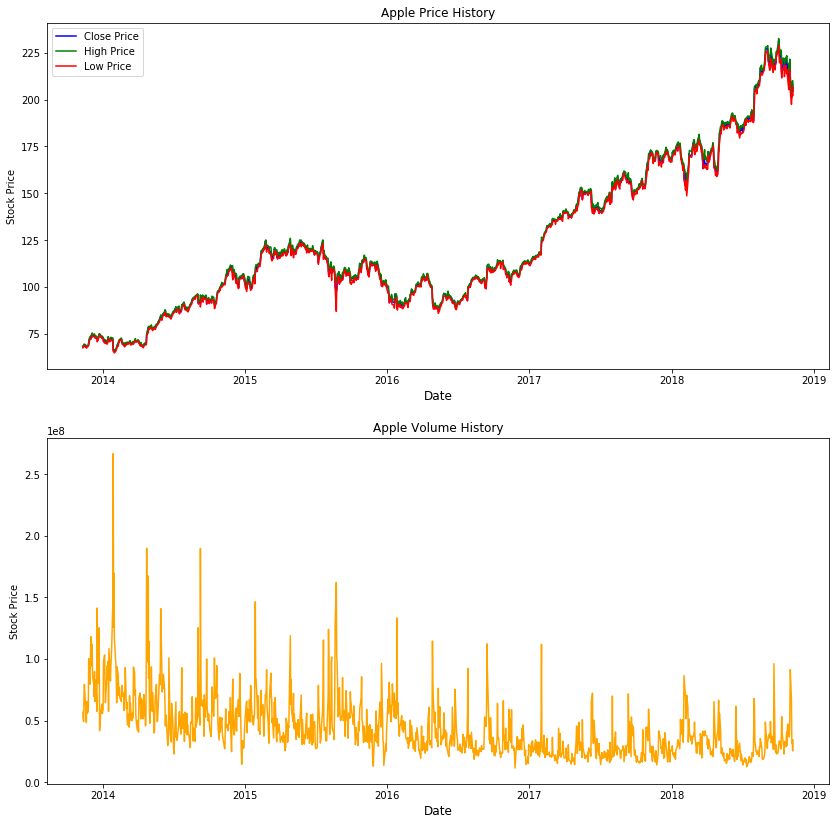

In [18]:
plotting(appl, "Apple")

In [26]:
# Verify number of companies...
df['Name'].nunique()

505

In [27]:
# Lets see how much growth these companies had shown each day. Then we will compare highest and lowest growing company

In [28]:
# Explore where the nulls are...
df.loc[df.isnull().sum(axis = 1).astype(bool)].nunique()

,date,open,high,low,close,volume,Name


In [29]:
# Get dates...
dates = df.loc[df.isnull().sum(axis = 1).astype(bool)]['date'].unique()

In [30]:
# Drop...
df.drop(np.arange(len(df))[df['date'].isin(dates)], inplace = True)

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [32]:
name, close = df[df['date'] == df['date'].min()][['Name', 'close']].T.values

In [33]:
df['Name'].values

array(['AAL', 'AAL', 'AAL', ..., 'ZTS', 'ZTS', 'ZTS'], dtype=object)

In [34]:
name.shape

(481,)

In [35]:
df['date'].min()

Timestamp('2013-11-11 00:00:00')

In [36]:
N = df[df['date']==df['date'].min()][['Name']].T.values.tolist()

In [37]:
df_short = df[df['Name'].isin(N[0])]

### Feature Engineering

#### Create 'growth' as a variable

In [38]:
# Obtain all names to corresponding close...
name, close = df_short[df_short['date'] == df_short['date'].min()][['Name', 'close']].T.values

# Map to dictionary...
base = {n : c for n, c in zip(name, close)}

# Use base to add Growth to data...
Base           = np.array(list(map(lambda x : base[x], df_short['Name'].values)))
df_short['growth'] = df_short['close'] / Base - 1

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
# Summary statistics...
df_short['growth'].describe()

count    604811.000000
mean          0.397176
std           0.669070
min          -0.936525
25%           0.048791
50%           0.258638
75%           0.595306
max          18.480930
Name: growth, dtype: float64

In [40]:
# large n will cause the later visualisation to slow down
n = 8

# last day of the year for all companies only showing Date, Name and Growth sorted by Growth...
obj = df_short.loc[df_short['date'] == df_short['date'].max()][['date', 'Name', 'growth']].sort_values('growth')

print('Largest fall in share price:')
display(obj.head(n))
print('Largest gain in share price:')
display(obj.tail(n))

Largest fall in share price:


,date,Name,growth
115318,2018-11-09,CHK,-0.855086
496724,2018-11-09,RRC,-0.759493
221561,2018-11-09,FCX,-0.664252
365542,2018-11-09,MAT,-0.626109
244837,2018-11-09,GE,-0.624506
404384,2018-11-09,NBL,-0.622790
168824,2018-11-09,DISCK,-0.621866
167564,2018-11-09,DISCA,-0.610119


Largest gain in share price:


,date,Name,growth
10079,2018-11-09,ADBE,3.358135
211481,2018-11-09,EW,3.782392
47874,2018-11-09,AMZN,3.832213
131698,2018-11-09,CNC,3.955084
65720,2018-11-09,AVGO,4.904603
410684,2018-11-09,NFLX,5.286563
40314,2018-11-09,AMD,5.296407
425804,2018-11-09,NVDA,12.846568


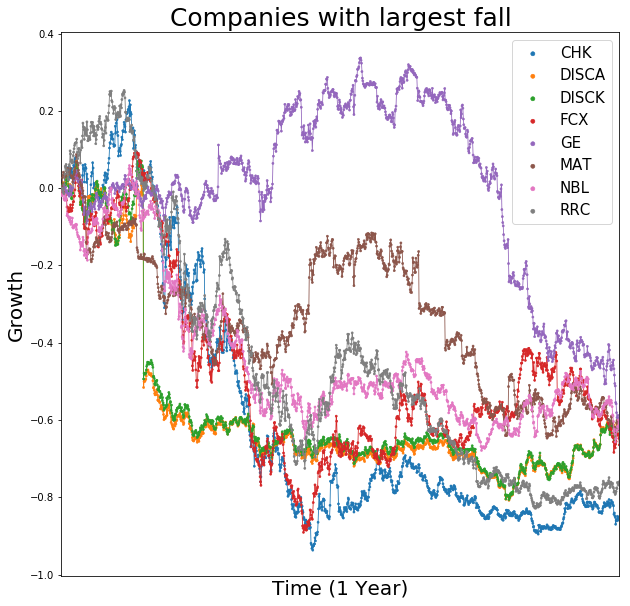

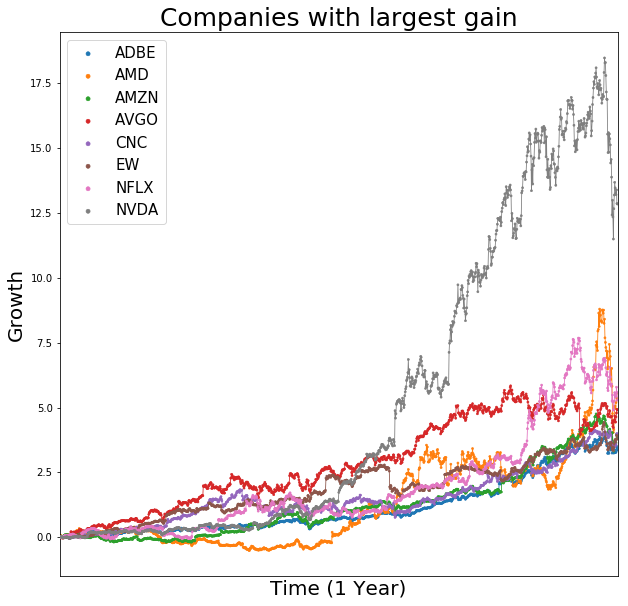

In [41]:
lo_names = obj.head(n)['Name']
hi_names = obj.tail(n)['Name']
names    = [lo_names, hi_names]
pre      = ['fall', 'gain']
title    = 'Companies with largest '

for i in range(2):
    # subset of data...
    sub = df_short[df_short['Name'].isin(names[i])].groupby(['Name', 'date'])['growth'].sum().reset_index()
    
    # create figure...
    plt.figure(figsize=(10, 10))
    
    sns.pointplot(x = 'date', y = 'growth', hue = 'Name', data = sub, scale = 0.3)
    
    # remove the 250 x ticks...
    plt.xticks([])
    
    # add title and x / y labels 
    plt.title(title + pre[i]  , size = 25)
    plt.xlabel('Time (1 Year)', size = 20)
    plt.ylabel('Growth'       , size = 20)
    
    # always add a legend and make sure it is readable
    plt.legend(markerscale = 2, prop = {'size' : 15})
    plt.savefig(str(i) + ".png", bbox_inches='tight', dpi=300)
    plt.savefig(str(i) + ".eps", format='eps', dpi=300)
    plt.show()

In [42]:
obj['growth'].sum(), obj['growth'].mean()

(380.36724605619196, 0.8127505257610936)

#### This means If we had invested \$1 in each of those 481 companies from the beginning, we would get an average gain of \$380


#### Calculate 'Moving Average' as the new feature

In [43]:
# Compute Close MA as one of the features

In [44]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604811 entries, 0 to 621820
Data columns (total 8 columns):
date      604811 non-null datetime64[ns]
open      604811 non-null float64
high      604811 non-null float64
low       604811 non-null float64
close     604811 non-null float64
volume    604811 non-null int64
Name      604811 non-null object
growth    604811 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 41.5+ MB


In [45]:
df_short['MA'] = df_short.rolling(window=50)['close'].mean()

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
df_short.head()

,date,open,high,low,close,volume,Name,growth,MA
0,2013-11-11,22.2732,22.4648,22.0911,22.2923,3508100,AAL,0.000000,NaN
1,2013-11-12,22.2827,24.4190,21.5547,22.5318,40091800,AAL,0.010744,NaN
2,2013-11-13,23.2024,23.2790,22.1582,22.3306,20087200,AAL,0.001718,NaN
3,2013-11-14,22.7905,22.8000,22.3977,22.6659,12641900,AAL,0.016759,NaN
4,2013-11-15,22.7330,23.0395,22.3402,22.8863,13660700,AAL,0.026646,NaN


In [124]:
# Let's analyze some of the stocks.
amzn = df_short.loc[df_short['Name'] == 'AMZN']
amzn.head()

,date,open,high,low,close,volume,Name,growth,MA
46615,2013-11-11,350.59,355.3700,348.060,354.378,2262538,AMZN,0.000000,152.527732
46616,2013-11-12,352.99,355.4826,347.282,349.530,2344304,AMZN,-0.013680,156.571592
46617,2013-11-13,347.40,356.2200,345.680,356.220,2777832,AMZN,0.005198,160.760192
46618,2013-11-14,357.39,368.9400,356.430,367.396,4164128,AMZN,0.036735,165.162566
46619,2013-11-15,367.63,372.9000,365.550,369.170,4494773,AMZN,0.041741,169.631052


In [372]:
### Plot the moving average

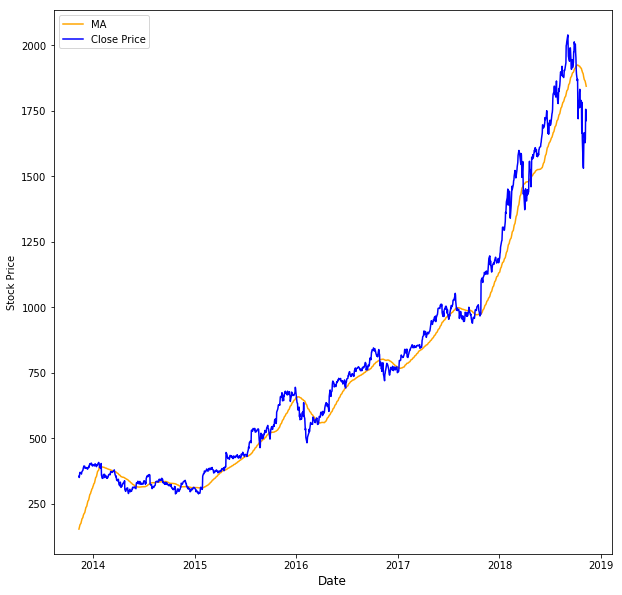

In [48]:
plt.figure(figsize=(10,10))
plt.plot(amzn["date"], amzn["MA"], color="orange")
plt.plot(amzn["date"], amzn["close"], color="blue")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price")
#plt.title(company +" Volume History")
plt.legend(['MA','Close Price'], loc='upper left')
plt.savefig("MA.png", bbox_inches='tight', dpi=300)
plt.savefig("MA.eps", format='eps', dpi=300)
plt.show()

### Linear Regression Full

In [225]:

def load_data_linear(stock):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    #sequence_length = seq_len + 1 # index starting from 0
    #result = []
    print(data.shape)
    
    row = round(0.9 * data.shape[0]) # 90% split
    train = data[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    
    print(x_train.shape)
    y_train = train[:, -1]
    print(y_train.shape)
    x_test = data[int(row):, :-1] 
    print(x_test.shape)
    y_test = data[int(row):, -1]
    print(y_test.shape)

    return [x_train, y_train, x_test, y_test]

In [127]:
#normalize data
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['date'] = min_max_scaler.fit_transform(df.date.values.reshape(-1,1))
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['growth'] = min_max_scaler.fit_transform(df.growth.values.reshape(-1,1))
    df['MA'] = min_max_scaler.fit_transform(df.MA.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,date,open,high,low,volume,Name,growth,MA,adj close
46615,0.000000,0.037743,0.036902,0.037050,0.051380,AMZN,0.038474,0.000000,0.038474
46616,0.000548,0.039111,0.036966,0.036600,0.054972,AMZN,0.035708,0.002282,0.035708
46617,0.001096,0.035924,0.037385,0.035674,0.074017,AMZN,0.039525,0.004645,0.039525
46618,0.001645,0.041620,0.044612,0.041891,0.134918,AMZN,0.045902,0.007129,0.045902
46619,0.002193,0.047459,0.046862,0.047166,0.149444,AMZN,0.046914,0.009650,0.046914


In [ ]:
scalar_y = MinMaxScaler()
scl_y=scalar_y.fit(Y_train_RFE.reshape(-1,1))
def prepare_plot_result_lin(model, X_test, y_test):  
    act = []
    pred = []
    #for i in range(X_test.shape[0]):
    Xt = model.predict(X_test)
        #print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i])))
    pred = scl_y.inverse_transform(Xt.reshape(-1,1))
    act = scl_y.inverse_transform(y_test.reshape(-1,1))
    result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})
    return result_df

In [ ]:
# build full Linear Regression Model - all features

In [125]:
amzn.head()

,date,open,high,low,close,volume,Name,growth,MA
46615,2013-11-11,350.59,355.3700,348.060,354.378,2262538,AMZN,0.000000,152.527732
46616,2013-11-12,352.99,355.4826,347.282,349.530,2344304,AMZN,-0.013680,156.571592
46617,2013-11-13,347.40,356.2200,345.680,356.220,2777832,AMZN,0.005198,160.760192
46618,2013-11-14,357.39,368.9400,356.430,367.396,4164128,AMZN,0.036735,165.162566
46619,2013-11-15,367.63,372.9000,365.550,369.170,4494773,AMZN,0.041741,169.631052


In [277]:
LR_FULL = amzn.copy()
LR_FULL['adj close'] = LR_FULL['close']
LR_FULL = LR_FULL.drop(['close'],1)

In [280]:
LR_FULL = LR_FULL.drop(['Name'],1)
LR_FULL = LR_FULL.drop(['growth'],1)
#LR_FULL = LR_FULL.drop(['MA'],1)
LR_FULL.head()

,date,open,high,low,volume,MA,adj close
46615,0.000000,0.037743,0.036902,0.037050,0.051380,0.000000,0.038474
46616,0.000548,0.039111,0.036966,0.036600,0.054972,0.002282,0.035708
46617,0.001096,0.035924,0.037385,0.035674,0.074017,0.004645,0.039525
46618,0.001645,0.041620,0.044612,0.041891,0.134918,0.007129,0.045902
46619,0.002193,0.047459,0.046862,0.047166,0.149444,0.009650,0.046914


In [278]:
LR_FULL = normalize_data(LR_FULL)

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [362]:
X_train_LR, Y_train_LR, X_test_LR, Y_test_LR = load_data_linear(LR_FULL) 


(1134, 6)
(1134,)
(126, 6)
(126,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [363]:
LR_FULL_model = linear_model.LinearRegression()

In [364]:
LR_FULL_model.fit(X_train_LR, y_train_LR)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [365]:
LR_FULL_model.score(X_test_LR,y_test_LR)#testing the linear regression model

-0.06698721736469393

In [366]:
math.sqrt(mean_squared_error(LR_FULL_model.predict(X_test_LR), y_test_LR))

0.24920754177185434

In [367]:
res_LR_Full = prepare_plot_result_lin(LR_FULL_model, X_test_LR, y_test_LR)

In [368]:
res_LR_Full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
pred    126 non-null float64
act     126 non-null float64
dtypes: float64(2)
memory usage: 2.0 KB


In [369]:
res_LR_Full.head()

,pred,act
0,0.253285,0.033124
1,0.226169,0.375719
2,0.228328,0.047604
3,0.246318,0.193989
4,0.240100,0.165166


### Linear Regression with Random Feature Elimination

In [126]:
df = amzn.copy()
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,date,open,high,low,volume,Name,growth,MA,adj close
46615,2013-11-11,350.59,355.3700,348.060,2262538,AMZN,0.000000,152.527732,354.378
46616,2013-11-12,352.99,355.4826,347.282,2344304,AMZN,-0.013680,156.571592,349.530
46617,2013-11-13,347.40,356.2200,345.680,2777832,AMZN,0.005198,160.760192,356.220
46618,2013-11-14,357.39,368.9400,356.430,4164128,AMZN,0.036735,165.162566,367.396
46619,2013-11-15,367.63,372.9000,365.550,4494773,AMZN,0.041741,169.631052,369.170


In [128]:
df = normalize_data(df)
df = df.drop(['Name'],1)
df.head()

,date,open,high,low,volume,growth,MA,adj close
46615,0.000000,0.037743,0.036902,0.037050,0.051380,0.038474,0.000000,0.038474
46616,0.000548,0.039111,0.036966,0.036600,0.054972,0.035708,0.002282,0.035708
46617,0.001096,0.035924,0.037385,0.035674,0.074017,0.039525,0.004645,0.039525
46618,0.001645,0.041620,0.044612,0.041891,0.134918,0.045902,0.007129,0.045902
46619,0.002193,0.047459,0.046862,0.047166,0.149444,0.046914,0.009650,0.046914


In [129]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

RFE_train, RFE_label_train, RFE_test, RFE_lable_test = load_data_linear(df)
model_RFE= linear_model.LinearRegression()
rfe = RFE(model_RFE, 3)
rfe = rfe.fit(RFE_train, RFE_label_train)
print(rfe.support_)
print(rfe.ranking_)


(1134, 7)
(1134,)
(126, 7)
(126,)
[False  True  True False False  True False]
[2 1 1 4 3 1 5]


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
# Select features
data_LRFS = df[['open','high','volume','adj close']]

In [253]:
# predictors = 'open', 'high', 'growth'
X_train_RFE, Y_train_RFE, X_test_RFE, Y_test_RFE = load_data_linear(data_LRFS) 
LR_RFE_model = linear_model.LinearRegression()
LR_RFE_model.fit(X_train_RFE, Y_train_RFE)

(1134, 3)
(1134,)
(126, 3)
(126,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [254]:
print(LR_RFE_model.score(X_test_RFE,Y_test_RFE))#testing the linear regression model
print(math.sqrt(mean_squared_error(LR_RFE_model.predict(X_test_RFE), Y_test_RFE)))

0.980870136644921
0.010123244455456568


In [257]:
res_LR_RFE_df = prepare_plot_result_lin(LR_RFE_model, X_test_RFE, Y_test_RFE)

In [258]:
res_LR_RFE_df.head()

,pred,act
0,0.551321,0.554930
1,0.558746,0.559734
2,0.558386,0.557358
3,0.551816,0.554177
4,0.555930,0.558951


### LSTM - ReLU

In [166]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 10days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [94]:
# build the model - Single hidden layer with Rectified Linear Unit as activation function

In [236]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='relu'))
    
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [168]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


In [176]:
LSTM_Relu = amzn.copy()

LSTM_Relu['adj close'] = LSTM_Relu['close']
LSTM_Relu= LSTM_Relu.drop(['close'],1)

In [177]:
LSTM_Relu = normalize_data(LSTM_Relu)

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [182]:
LSTM_Relu = LSTM_Relu.drop(['Name'],1)

In [183]:
window = 10
X_train_LSTM1, y_train_LSTM1, X_test_LSTM1, y_test_LSTM1 = load_data(LSTM_Relu, window)
print (X_train_LSTM1.shape, y_train_LSTM1.shape, y_test_LSTM1.shape)

(1124, 10, 8) (1124,) (125,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [316]:
X_test_LSTM1.shape

(125, 10, 8)

In [237]:
LSTM_Relu_model = build_model([8,window,1])

Compilation Time :  0.0271759033203125


In [238]:
LSTM_1_model = LSTM_Relu_model.fit(X_train_LSTM1,y_train_LSTM1,batch_size=512,epochs=300,validation_split=0.1,verbose=1)

Train on 1011 samples, validate on 113 samples
Epoch 1/300
1011/1011 [==============================] - 2s 2ms/step - loss: 0.0502 - acc: 9.8912e-04 - val_loss: 0.3700 - val_acc: 0.0000e+00
Epoch 2/300
1011/1011 [==============================] - 0s 232us/step - loss: 0.0423 - acc: 9.8912e-04 - val_loss: 0.3056 - val_acc: 0.0000e+00
Epoch 3/300
1011/1011 [==============================] - 0s 250us/step - loss: 0.0311 - acc: 9.8912e-04 - val_loss: 0.2022 - val_acc: 0.0000e+00
Epoch 4/300
1011/1011 [==============================] - 0s 257us/step - loss: 0.0148 - acc: 9.8912e-04 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 5/300
1011/1011 [==============================] - 0s 269us/step - loss: 0.0046 - acc: 9.8912e-04 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 6/300
1011/1011 [==============================] - 0s 262us/step - loss: 0.0106 - acc: 9.8912e-04 - val_loss: 0.0153 - val_acc: 0.0000e+00
Epoch 7/300
1011/1011 [==============================] - 0s 247us/step - loss: 0.0028

Epoch 56/300
1011/1011 [==============================] - 0s 277us/step - loss: 3.1674e-04 - acc: 9.8912e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 57/300
1011/1011 [==============================] - 0s 319us/step - loss: 3.0956e-04 - acc: 9.8912e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 58/300
1011/1011 [==============================] - 0s 272us/step - loss: 3.0628e-04 - acc: 9.8912e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 59/300
1011/1011 [==============================] - 0s 353us/step - loss: 2.9610e-04 - acc: 9.8912e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 60/300
1011/1011 [==============================] - 0s 326us/step - loss: 3.4147e-04 - acc: 9.8912e-04 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 61/300
1011/1011 [==============================] - 0s 313us/step - loss: 3.2609e-04 - acc: 9.8912e-04 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 62/300
1011/1011 [==============================] - 0s 249us/step - loss: 3.0136e-04 - acc: 9.

1011/1011 [==============================] - 0s 251us/step - loss: 2.5744e-04 - acc: 9.8912e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 111/300
1011/1011 [==============================] - 0s 245us/step - loss: 2.4556e-04 - acc: 9.8912e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 112/300
1011/1011 [==============================] - 0s 252us/step - loss: 2.5610e-04 - acc: 9.8912e-04 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 113/300
1011/1011 [==============================] - 0s 252us/step - loss: 2.3364e-04 - acc: 9.8912e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 114/300
1011/1011 [==============================] - 0s 255us/step - loss: 2.5046e-04 - acc: 9.8912e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 115/300
1011/1011 [==============================] - 0s 247us/step - loss: 2.2843e-04 - acc: 9.8912e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 116/300
1011/1011 [==============================] - 0s 244us/step - loss: 2.4100e-04 - acc: 9.8912e-0

1011/1011 [==============================] - 0s 254us/step - loss: 2.1418e-04 - acc: 9.8912e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 165/300
1011/1011 [==============================] - 0s 252us/step - loss: 2.2696e-04 - acc: 9.8912e-04 - val_loss: 9.6996e-04 - val_acc: 0.0000e+00
Epoch 166/300
1011/1011 [==============================] - 0s 252us/step - loss: 2.2034e-04 - acc: 9.8912e-04 - val_loss: 9.7397e-04 - val_acc: 0.0000e+00
Epoch 167/300
1011/1011 [==============================] - 0s 249us/step - loss: 2.2501e-04 - acc: 9.8912e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 168/300
1011/1011 [==============================] - 0s 256us/step - loss: 2.0331e-04 - acc: 9.8912e-04 - val_loss: 8.4786e-04 - val_acc: 0.0000e+00
Epoch 169/300
1011/1011 [==============================] - 0s 253us/step - loss: 2.1989e-04 - acc: 9.8912e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 170/300
1011/1011 [==============================] - 0s 253us/step - loss: 2.1934e-04 - ac

1011/1011 [==============================] - 0s 255us/step - loss: 1.9477e-04 - acc: 9.8912e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 218/300
1011/1011 [==============================] - 0s 256us/step - loss: 1.8218e-04 - acc: 9.8912e-04 - val_loss: 6.5937e-04 - val_acc: 0.0000e+00
Epoch 219/300
1011/1011 [==============================] - 0s 255us/step - loss: 1.7723e-04 - acc: 9.8912e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 220/300
1011/1011 [==============================] - 0s 255us/step - loss: 1.8313e-04 - acc: 9.8912e-04 - val_loss: 6.8645e-04 - val_acc: 0.0000e+00
Epoch 221/300
1011/1011 [==============================] - 0s 253us/step - loss: 1.9668e-04 - acc: 9.8912e-04 - val_loss: 9.2730e-04 - val_acc: 0.0000e+00
Epoch 222/300
1011/1011 [==============================] - 0s 254us/step - loss: 2.0445e-04 - acc: 9.8912e-04 - val_loss: 7.0256e-04 - val_acc: 0.0000e+00
Epoch 223/300
1011/1011 [==============================] - 0s 253us/step - loss: 1.9635e-04 

1011/1011 [==============================] - 0s 255us/step - loss: 1.6886e-04 - acc: 9.8912e-04 - val_loss: 6.7182e-04 - val_acc: 0.0000e+00
Epoch 271/300
1011/1011 [==============================] - 0s 241us/step - loss: 1.7326e-04 - acc: 9.8912e-04 - val_loss: 6.5177e-04 - val_acc: 0.0000e+00
Epoch 272/300
1011/1011 [==============================] - 0s 242us/step - loss: 1.7730e-04 - acc: 9.8912e-04 - val_loss: 6.7355e-04 - val_acc: 0.0000e+00
Epoch 273/300
1011/1011 [==============================] - 0s 244us/step - loss: 1.7118e-04 - acc: 9.8912e-04 - val_loss: 6.3555e-04 - val_acc: 0.0000e+00
Epoch 274/300
1011/1011 [==============================] - 0s 242us/step - loss: 1.7616e-04 - acc: 9.8912e-04 - val_loss: 7.7277e-04 - val_acc: 0.0000e+00
Epoch 275/300
1011/1011 [==============================] - 0s 243us/step - loss: 1.9381e-04 - acc: 9.8912e-04 - val_loss: 6.4510e-04 - val_acc: 0.0000e+00
Epoch 276/300
1011/1011 [==============================] - 0s 243us/step - loss: 1.6

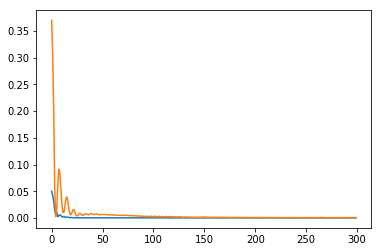

In [239]:
plt.plot(LSTM_1_model.history['loss'])
plt.plot(LSTM_1_model.history['val_loss'])

In [240]:
train_score, test_score = model_score(LSTM_Relu_model, X_train_LSTM1, y_train_LSTM1, X_test_LSTM1, y_test_LSTM1)

Train Score: 0.00015 MSE (0.01232 RMSE)
Test Score: 0.00130 MSE (0.03609 RMSE)


In [353]:
scalar_y = MinMaxScaler()
scl_y=scalar_y.fit(y_train_LSTM1.reshape(-1,1))
def prepare_plot_result_LSTM(model, X_test, y_test, window=22):  
    act = []
    pred = []
    for i in range(X_test.shape[0]):
        Xt = model.predict(X_test[i].reshape(1,window,8))
        #print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
        pred.append(scl_y.inverse_transform(Xt))
        act.append(scl_y.inverse_transform(y_test[i].reshape(-1,1)))
        result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})
    return result_df

In [354]:
res_LSTM1_df = prepare_plot_result_LSTM(LSTM_Relu_model, X_test_LSTM1, y_test_LSTM1, window)

In [355]:
res_LSTM1_df.head()

,pred,act
0,0.571082,0.554930
1,0.571221,0.559734
2,0.571070,0.557358
3,0.570604,0.554177
4,0.569569,0.558951


### LSTM-Linear

In [194]:
LSTM_Linear = amzn.copy()
LSTM_Linear['adj close'] = LSTM_Linear['close']
LSTM_Linear = LSTM_Linear.drop(['close'],1)

In [195]:
LSTM_Linear = normalize_data(LSTM_Linear)

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [196]:
LSTM_Linear = LSTM_Linear.drop(['Name'],1)
LSTM_Linear.head()

,date,open,high,low,volume,growth,MA,adj close
46615,0.000000,0.037743,0.036902,0.037050,0.051380,0.038474,0.000000,0.038474
46616,0.000548,0.039111,0.036966,0.036600,0.054972,0.035708,0.002282,0.035708
46617,0.001096,0.035924,0.037385,0.035674,0.074017,0.039525,0.004645,0.039525
46618,0.001645,0.041620,0.044612,0.041891,0.134918,0.045902,0.007129,0.045902
46619,0.002193,0.047459,0.046862,0.047166,0.149444,0.046914,0.009650,0.046914


In [197]:
window = 10
X_train_LSTM2, y_train_LSTM2, X_test_LSTM2, y_test_LSTM2 = load_data(LSTM_Linear, window)
print (X_train_LSTM2.shape, y_train_LSTM2.shape, y_test_LSTM2.shape)

(1124, 10, 8) (1124,) (125,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Build the model - Single hidden layer LSTM with Linear activation function

In [225]:

def build_model_lstm2(layers):
    d=0.3
    model = Sequential()
    model.add(LSTM(256,input_shape=(layers[1],layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(32,kernel_initializer="uniform",activation='linear'))        
    model.add(Dense(1))
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model
    
#Reshape data for (Sample,Timestep,Features) 
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting


In [226]:
LSTM2_model = build_model_lstm2([8,window,1])

Compilation Time :  0.02451467514038086


In [227]:
LSTM2_trained = LSTM2_model.fit(X_train_LSTM2,y_train_LSTM2,epochs=300,validation_data=(X_test_LSTM2,y_test_LSTM2),shuffle=False)

Train on 1124 samples, validate on 125 samples
Epoch 1/300
1124/1124 [==============================] - 2s 2ms/step - loss: 0.0018 - acc: 8.8968e-04 - val_loss: 0.0012 - val_acc: 0.0080
Epoch 2/300
1124/1124 [==============================] - 1s 539us/step - loss: 0.0020 - acc: 8.8968e-04 - val_loss: 0.0031 - val_acc: 0.0080
Epoch 3/300
1124/1124 [==============================] - 1s 576us/step - loss: 0.0013 - acc: 8.8968e-04 - val_loss: 0.0067 - val_acc: 0.0080
Epoch 4/300
1124/1124 [==============================] - 1s 567us/step - loss: 0.0029 - acc: 8.8968e-04 - val_loss: 0.0029 - val_acc: 0.0080
Epoch 5/300
1124/1124 [==============================] - 1s 585us/step - loss: 0.0015 - acc: 8.8968e-04 - val_loss: 0.0010 - val_acc: 0.0080
Epoch 6/300
1124/1124 [==============================] - 1s 589us/step - loss: 0.0012 - acc: 8.8968e-04 - val_loss: 0.0017 - val_acc: 0.0080
Epoch 7/300
1124/1124 [==============================] - 1s 605us/step - loss: 0.0011 - acc: 8.8968e-04 - val

1124/1124 [==============================] - 1s 609us/step - loss: 4.7848e-04 - acc: 8.8968e-04 - val_loss: 0.0012 - val_acc: 0.0080
Epoch 57/300
1124/1124 [==============================] - 1s 605us/step - loss: 3.8335e-04 - acc: 8.8968e-04 - val_loss: 5.0122e-04 - val_acc: 0.0080
Epoch 58/300
1124/1124 [==============================] - 1s 587us/step - loss: 2.7371e-04 - acc: 8.8968e-04 - val_loss: 4.9774e-04 - val_acc: 0.0080
Epoch 59/300
1124/1124 [==============================] - 1s 592us/step - loss: 2.2263e-04 - acc: 8.8968e-04 - val_loss: 5.7689e-04 - val_acc: 0.0080
Epoch 60/300
1124/1124 [==============================] - 1s 595us/step - loss: 3.9060e-04 - acc: 8.8968e-04 - val_loss: 4.9858e-04 - val_acc: 0.0080
Epoch 61/300
1124/1124 [==============================] - 1s 598us/step - loss: 5.9173e-04 - acc: 8.8968e-04 - val_loss: 5.0509e-04 - val_acc: 0.0080
Epoch 62/300
1124/1124 [==============================] - 1s 585us/step - loss: 2.0354e-04 - acc: 8.8968e-04 - val_lo

1124/1124 [==============================] - 1s 606us/step - loss: 0.0029 - acc: 8.8968e-04 - val_loss: 0.0024 - val_acc: 0.0080
Epoch 112/300
1124/1124 [==============================] - 1s 600us/step - loss: 0.0020 - acc: 8.8968e-04 - val_loss: 0.0016 - val_acc: 0.0080
Epoch 113/300
1124/1124 [==============================] - 1s 621us/step - loss: 9.0842e-04 - acc: 8.8968e-04 - val_loss: 7.6930e-04 - val_acc: 0.0080
Epoch 114/300
1124/1124 [==============================] - 1s 633us/step - loss: 0.0034 - acc: 8.8968e-04 - val_loss: 0.0011 - val_acc: 0.0080
Epoch 115/300
1124/1124 [==============================] - 1s 613us/step - loss: 9.9882e-04 - acc: 8.8968e-04 - val_loss: 0.0031 - val_acc: 0.0080
Epoch 116/300
1124/1124 [==============================] - 1s 602us/step - loss: 8.6346e-04 - acc: 8.8968e-04 - val_loss: 0.0017 - val_acc: 0.0080
Epoch 117/300
1124/1124 [==============================] - 1s 614us/step - loss: 5.3090e-04 - acc: 8.8968e-04 - val_loss: 7.3552e-04 - val_a

1124/1124 [==============================] - 1s 582us/step - loss: 3.9403e-04 - acc: 8.8968e-04 - val_loss: 7.6223e-04 - val_acc: 0.0080
Epoch 167/300
1124/1124 [==============================] - 1s 580us/step - loss: 5.3747e-04 - acc: 8.8968e-04 - val_loss: 0.0019 - val_acc: 0.0080
Epoch 168/300
1124/1124 [==============================] - 1s 588us/step - loss: 7.2980e-04 - acc: 8.8968e-04 - val_loss: 8.9309e-04 - val_acc: 0.0080
Epoch 169/300
1124/1124 [==============================] - 1s 691us/step - loss: 9.2032e-04 - acc: 8.8968e-04 - val_loss: 0.0015 - val_acc: 0.0080
Epoch 170/300
1124/1124 [==============================] - 1s 729us/step - loss: 0.0012 - acc: 8.8968e-04 - val_loss: 8.4106e-04 - val_acc: 0.0080
Epoch 171/300
1124/1124 [==============================] - 1s 735us/step - loss: 4.5605e-04 - acc: 8.8968e-04 - val_loss: 0.0015 - val_acc: 0.0080
Epoch 172/300
1124/1124 [==============================] - 1s 962us/step - loss: 7.7579e-04 - acc: 8.8968e-04 - val_loss: 7.

Epoch 221/300
1124/1124 [==============================] - 1s 556us/step - loss: 8.7403e-04 - acc: 8.8968e-04 - val_loss: 0.0011 - val_acc: 0.0080
Epoch 222/300
1124/1124 [==============================] - 1s 566us/step - loss: 8.1359e-04 - acc: 8.8968e-04 - val_loss: 6.4643e-04 - val_acc: 0.0080
Epoch 223/300
1124/1124 [==============================] - 1s 565us/step - loss: 5.3149e-04 - acc: 8.8968e-04 - val_loss: 7.8410e-04 - val_acc: 0.0080
Epoch 224/300
1124/1124 [==============================] - 1s 550us/step - loss: 5.5224e-04 - acc: 8.8968e-04 - val_loss: 5.7675e-04 - val_acc: 0.0080
Epoch 225/300
1124/1124 [==============================] - 1s 552us/step - loss: 5.3073e-04 - acc: 8.8968e-04 - val_loss: 7.2084e-04 - val_acc: 0.0080
Epoch 226/300
1124/1124 [==============================] - 1s 578us/step - loss: 6.2011e-04 - acc: 8.8968e-04 - val_loss: 6.5805e-04 - val_acc: 0.0080
Epoch 227/300
1124/1124 [==============================] - 1s 548us/step - loss: 7.6185e-04 - acc:

Epoch 276/300
1124/1124 [==============================] - 1s 562us/step - loss: 4.0032e-04 - acc: 8.8968e-04 - val_loss: 4.1639e-04 - val_acc: 0.0080
Epoch 277/300
1124/1124 [==============================] - 1s 563us/step - loss: 5.5982e-04 - acc: 8.8968e-04 - val_loss: 4.5966e-04 - val_acc: 0.0080
Epoch 278/300
1124/1124 [==============================] - 1s 553us/step - loss: 6.1690e-04 - acc: 8.8968e-04 - val_loss: 4.4806e-04 - val_acc: 0.0080
Epoch 279/300
1124/1124 [==============================] - 1s 585us/step - loss: 8.6342e-04 - acc: 8.8968e-04 - val_loss: 4.9444e-04 - val_acc: 0.0080
Epoch 280/300
1124/1124 [==============================] - 1s 570us/step - loss: 6.2964e-04 - acc: 8.8968e-04 - val_loss: 6.8649e-04 - val_acc: 0.0080
Epoch 281/300
1124/1124 [==============================] - 1s 558us/step - loss: 6.0732e-04 - acc: 8.8968e-04 - val_loss: 6.3146e-04 - val_acc: 0.0080
Epoch 282/300
1124/1124 [==============================] - 1s 574us/step - loss: 6.9274e-04 - 

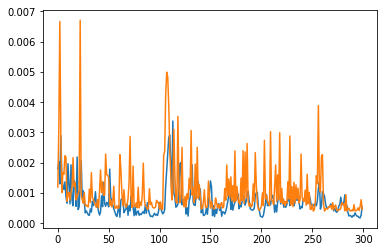

In [228]:
plt.plot(LSTM2_trained.history['loss'])
plt.plot(LSTM2_trained.history['val_loss'])

In [229]:
train_score, test_score = model_score(LSTM2_model, X_train_LSTM2, y_train_LSTM2, X_test_LSTM2, y_test_LSTM2)

Train Score: 0.00181 MSE (0.04249 RMSE)
Test Score: 0.00046 MSE (0.02137 RMSE)


In [356]:
res_LSTM2_df = prepare_plot_result_LSTM(LSTM2_model, X_test_LSTM2, y_test_LSTM2, window)

In [357]:
res_LSTM2_df.head()

,pred,act
0,0.576321,0.554930
1,0.564256,0.559734
2,0.568711,0.557358
3,0.568524,0.554177
4,0.566200,0.558951


### Plot predictions

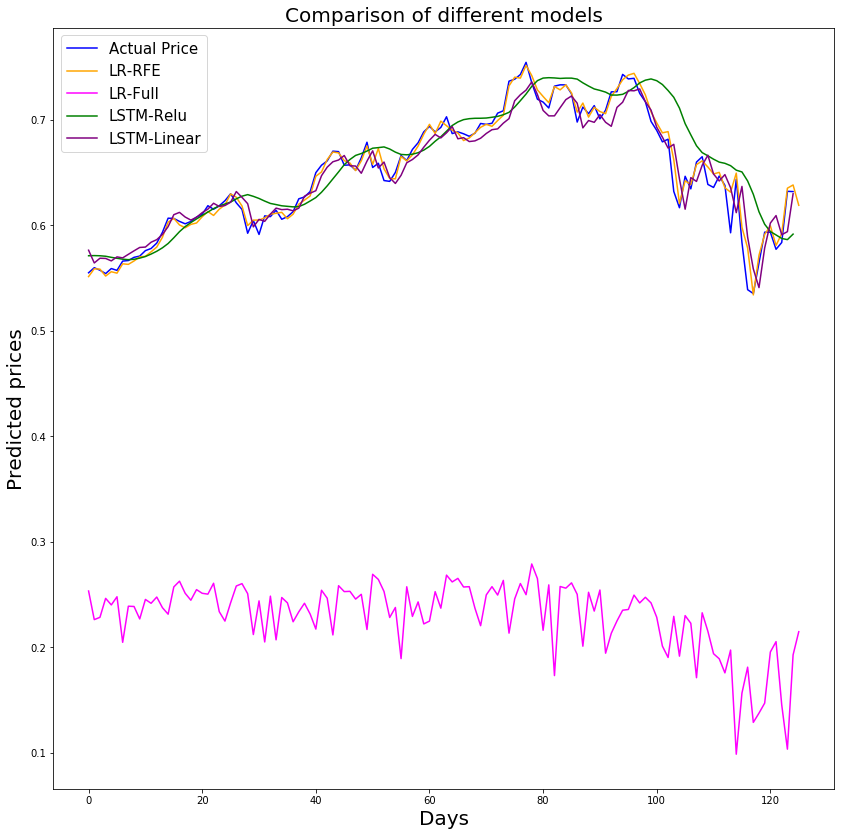

In [371]:
#def plots():
f, ax = plt.subplots(1, 1, figsize=(14,14))
#plt.figure(figsize=(20,10))
ax.plot(res_LSTM1_df["act"], 'b-')
ax.plot(res_LR_RFE_df["pred"], color="orange")
ax.plot(res_LR_Full["pred"], color="magenta")
ax.plot(res_LSTM1_df["pred"], color="green")
ax.plot(res_LSTM2_df["pred"], color="purple")
    
#plt.plot(res_df["pred"], color="blue")
ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Predicted prices", fontsize=20)
ax.set_title("Comparison of different models", fontsize = 20)
plt.legend(['Actual Price', 'LR-RFE', 'LR-Full','LSTM-Relu', 'LSTM-Linear'], loc='upper left', fontsize=15)
plt.savefig("plot.png", bbox_inches='tight', dpi=300)
plt.savefig("plot.eps", format='eps', dpi=300)
plt.show()
    

LR-Full is quite far from predicting the actual prices, hence has the highest RMSE scores. LR-RFE,  surprisingly does extremely well on the test data, predicting nearly actual prices capturing local and global trends quite accurately. LSTM-ReLU is able to smooth out most of the noise in daily fluctuations and captures the overall rise and fall of prices. LSTM-Linear, on the other hand, does a great job at predicting daily fluctuations in prices as well as the global trend. However, it is unable to beat the LR-RFE model. 


### Test on unknown data

In [318]:
df_test = pd.read_csv("all_stocks_1month.csv")
df_test = df_test.dropna() 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9756 entries, 0 to 9755
Data columns (total 7 columns):
date      9756 non-null object
open      9756 non-null float64
high      9756 non-null float64
low       9756 non-null float64
close     9756 non-null float64
volume    9756 non-null int64
Name      9756 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 609.8+ KB


In [319]:
# Obtain all names to corresponding close...
name, close = df_test[df_test['date'] == df_test['date'].min()][['Name', 'close']].T.values

# Map to dictionary...
base = {n : c for n, c in zip(name, close)}

# Use base to add Growth to data...
Base           = np.array(list(map(lambda x : base[x], df_test['Name'].values)))
df_test['growth'] = df_test['close'] / Base - 1

In [320]:
df_test['MA'] = df_test.rolling(window=50)['close'].mean()

In [321]:
# change date to datetime type of variable
df_test['date'] = pd.to_datetime(df_test['date'])
df_test=df_test.dropna()

In [322]:
df_test['adj close'] = df_test['close']
df_test=df_test.drop(['close'],1)

In [323]:
df_test = normalize_data(df_test)
df_test.head()

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sdoomra/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,date,open,high,low,volume,Name,growth,MA,adj close
49,0.482759,0.099262,0.099466,0.101298,0.003247,AAP,0.426135,0.123808,0.099060
50,0.517241,0.099188,0.099315,0.099950,0.006393,AAP,0.426366,0.127087,0.099083
51,0.620690,0.099862,0.099809,0.099857,0.003958,AAP,0.427404,0.130395,0.099185
52,0.655172,0.100513,0.100900,0.100303,0.007116,AAP,0.429134,0.133732,0.099354
53,0.724138,0.098356,0.098238,0.097484,0.005558,AAP,0.415117,0.137017,0.097981


In [324]:
amzn_test = df_test.loc[df_test['Name'] == 'AMZN']
amzn_test.head()

,date,open,high,low,volume,Name,growth,MA,adj close
729,0.000000,0.893347,0.913548,0.893793,0.040309,AMZN,0.434095,0.175932,0.913606
730,0.034483,0.897020,0.907726,0.909196,0.028913,AMZN,0.417494,0.210670,0.898900
731,0.137931,0.891083,0.888979,0.868818,0.037233,AMZN,0.365758,0.243651,0.853070
732,0.172414,0.812127,0.862827,0.820568,0.052140,AMZN,0.355024,0.276204,0.843562
733,0.206897,0.871829,0.871415,0.875555,0.027228,AMZN,0.368590,0.309339,0.855579


In [326]:
amzn_test = amzn_test.drop(['Name'],1)

In [317]:
def load_test_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 10days
    
    result = np.array(result)
    x_test = result[:, :-1] 
    y_test = result[:, -1][:,-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_test, y_test]

In [327]:
amzn_X_test, amzn_y_test = load_test_data(amzn_test,10)

/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### RMSE on Unknown data

#### LSTM-ReLU model

In [338]:
testScore_1 = LSTM_Relu_model.evaluate(amzn_X_test, amzn_y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore_1[0], math.sqrt(testScore_1[0])))

Test Score: 0.01709 MSE (0.13071 RMSE)


#### LSTM-Linear model

In [332]:
testScore_2 = LSTM2_model.evaluate(amzn_X_test, amzn_y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore_2[0], math.sqrt(testScore_2[0])))

Test Score: 0.01150 MSE (0.10724 RMSE)


In [341]:
# This function is to split unknown dataset for linear models
# Note: there is no training set returned. Only test sets should be returned to make predicitons
def load_test_linear(stock):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    x_test = data[:, :-1] 
    print(x_test.shape)
    y_test = data[:, -1]
    print(y_test.shape)

    return [x_test, y_test]

In [347]:
amzn_LR_test=amzn_test.drop(['MA'],1)

In [348]:
amzn_LR_X_test, amzn_LR_y_test = load_test_linear(amzn_LR_test)

(20, 6)
(20,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Linear Regression - Full

In [349]:
print(math.sqrt(mean_squared_error(LR_FULL_model.predict(amzn_LR_X_test), amzn_LR_y_test)))

0.48554309680207064


In [350]:
amzn_RFE = amzn_test[['open','high','volume','adj close']]

In [351]:
amzn_RFE_X_test, amzn_RFE_y_test = load_test_linear(amzn_RFE)

(20, 3)
(20,)


/Users/sdoomra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Linear Regression - RFE

In [352]:
print(math.sqrt(mean_squared_error(LR_RFE_model.predict(amzn_RFE_X_test), amzn_RFE_y_test)))

0.02238881748107535
